<a href="https://colab.research.google.com/github/iamnikhilpal/deeplearning-practice/blob/main/Identify_fake_covid_information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The data
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
!pip install textstat lexicalrichness

     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 1.9MB 13.0MB/s 
  Created wheel for lexicalrichness: filename=lexicalrichness-0.1.3-py2.py3-none-any.whl size=8741 sha256=354fdfa1e95635989514ef6a4403723cd0e8a38c1708643169a409753051ec89
  Stored in directory: /root/.cache/pip/wheels/ac/04/68/c48c4001edf1647b80b549897fd80082286ec253e343c73116
Successfully built lexicalrichness


In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.tag import pos_tag
from nltk import word_tokenize
from collections import Counter

import textstat
from lexicalrichness import LexicalRichness

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [ ]:
pd.set_option('display.max_columns', 500)
df = pd.read_csv('./sample_data/corona_fake.csv')
df

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake
...,...,...,...,...
1159,Could the Power of the Sun Slow the Coronavirus?,A study suggests that ultraviolet rays could s...,https://www.nytimes.com/,TRUE
1160,Key evidence for coronavirus spread is flawed ...,"Last week, a medical journal reported that a b...",https://www.nytimes.com/,TRUE
1161,Summer Heat May Not Diminish Coronavirus Strength,"A new report, sent to the White House science ...",https://www.nytimes.com/,TRUE
1162,How Long Will a Vaccine Really Take?,A vaccine would be the ultimate weapon against...,https://www.nytimes.com/,TRUE


In [ ]:
# standardizing the label
df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)

# Filling the labels for NaN 
df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

In [ ]:
df.isnull().sum()

title     0
text      0
source    0
label     0
dtype: int64

In [ ]:
# Capital letters in Title
df['title_num_uppercase'] = df['title'].str.count(r'[A-Z]')
df['text_num_uppercase'] = df['text'].str.count(r'[A-Z]')
df['text_len'] = df['text'].str.len()
df['text_pct_uppercase'] = df.text_num_uppercase.div(df.text_len) # pct -> percentage

x1 = df.loc[df['label'] == 'TRUE']['title_num_uppercase']
x2 = df.loc[df['label'] == 'FAKE']['title_num_uppercase']

group_labels = ['TRUE','FAKE']
colors = ['rgb(0,0,100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels, colors=colors
)

fig.update_layout(title_text='Distribution of upppercase in title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE', marker_color='rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name='FAKE', marker_color='rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Capital Letter in title', template="plotly_white")
fig.show()

In [ ]:
# By above graphs we can say that Fake news has way more words that appear in capital letter in the title.

In [ ]:
# Stop words in title
df['title_num_stop_words'] = df['title'].str.split().apply(lambda x: len(set(x) & stop_words))
df['text_num_stop_words'] = df['text'].str.split().apply(lambda x: len(set(x) & stop_words))
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['text_pct_stop_words'] = df['text_num_stop_words'] / df['text_word_count']

x1 = df.loc[df['label'] == 'TRUE']['title_num_stop_words']
x2 = df.loc[df['label'] == 'FAKE']['title_num_stop_words']
group_labels = ['TRUE', 'FAKE']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot([x1, x2], group_labels, colors=colors)

fig.update_layout(title_text='Distribution of Stop words in title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE', marker_color='rgb(0,0,100)'))
fig.add_trace(go.Box(y=x2, name='FAKE', marker_color='rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of stop words in title', template="plotly_white")
fig.show()

In [ ]:
# From above graph we can say that fake news title have fewer stop-words that those of real
df.columns

Index(['title', 'text', 'source', 'label', 'title_num_uppercase',
       'text_num_uppercase', 'text_len', 'text_pct_uppercase',
       'title_num_stop_words', 'text_num_stop_words', 'text_word_count',
       'text_pct_stop_words'],
      dtype='object')

In [ ]:
# Proper Noun in Title
df.drop(['text_num_uppercase', 'text_num_uppercase', 'text_num_stop_words', 'text_word_count'], axis=1, inplace=True)
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())
df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)

df = df[['title', 'text', 'source', 'label', 'title_num_uppercase', 'text_pct_uppercase', 'title_num_stop_words', 'text_pct_stop_words', 'NNP']].rename(columns={'NNP': 'NNP_title'})
x1 = df.loc[df['label'] == 'TRUE']['NNP_title']
x2 = df.loc[df['label'] == 'FAKE']['NNP_title']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
fig = ff.create_distplot(
    [x1, x2], group_labels, colors=colors
)
fig.update_layout(title_text='Number of Proper nouns in title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE', marker_color='rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name='FAKE', marker_color='rgb(0, 200, 200)'))

fig.update_layout(title_text='Box plot of Proper nouns in title', template="plotly_white")
fig.show()

In [ ]:
# Above graph say, Fake news title have more proper nouns, Apparently the use of proper nouns in titles are very significant in differentiating fake from real

In [ ]:
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())
df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)

In [ ]:
df['num_negation'] = df['text'].str.lower().str.count("no|not|never|none|nothing|nobody|neither|nowhere|hardly|scarcely|barely|doesn’t|isn’t|wasn’t|shouldn’t|wouldn’t|couldn’t|won’t|can't|don't")

df['num_interrogatives_title'] = df['title'].str.lower().str.count("what|who|when|where|which|why|how")

df['num_interrogatives_text'] = df['text'].str.lower().str.count("what|who|when|where|which|why|how")


In [ ]:
reading_ease = []
for doc in df['text']:
  reading_ease.append(textstat.flesch_reading_ease(doc))

smog = []
for doc in df['text']:
  smog.append(textstat.smog_index(doc))

kincaid_grade = []
for doc in df['text']:
  kincaid_grade.append(textstat.flesch_kincaid_grade(doc))

liau_index = []
for doc in df['text']:
  liau_index.append(textstat.coleman_liau_index(doc))

readability_index = []
for doc in df['text']:
  readability_index.append(textstat.automated_readability_index(doc))

readability_score = []
for doc in df['text']:
  readability_score.append(textstat.dale_chall_readability_score(doc))

difficult_words = []
for doc in df['text']:
  difficult_words.append(textstat.difficult_words(doc))


write_formula = []
for doc in df['text']:
  write_formula.append(textstat.linsear_write_formula(doc))


gunning_fog = []
for doc in df['text']:
  gunning_fog.append(textstat.gunning_fog(doc))


text_standard = []
for doc in df['text']:
  text_standard.append(textstat.text_standard(doc))

df['flesch_reading_ease'] = reading_ease
df['smog_index'] = smog
df['flesch_kincaid_grade'] = kincaid_grade
df['automated_readability_index'] = readability_index
df['dale_chall_readability_score'] = readability_score
df['difficult_words'] = difficult_words
df['linsear_write_formula'] = write_formula
df['gunning_fog'] = gunning_fog
df['text_standard'] = text_standard


In [ ]:
ttr = []
for doc in df['text']:
  lex = LexicalRichness(doc)
  ttr.append(lex.ttr)

df['ttr'] = ttr

In [ ]:
df['num_powerWords_text'] = df['text'].str.lower().str.count('improve|trust|immediately|discover|profit|learn|know|understand|powerful|best|win|more|bonus|exclusive|extra|you|free|health|guarantee|new|proven|safety|money|now|today|results|protect|help|easy|amazing|latest|extraordinary|how to|worst|ultimate|hot|first|big|anniversary|premiere|basic|complete|save|plus|create')
df['num_casualWords_text'] = df['text'].str.lower().str.count('make|because|how|why|change|use|since|reason|therefore|result')
df['num_tentativeWords_text'] = df['text'].str.lower().str.count('may|might|can|could|possibly|probably|it is likely|it is unlikely|it is possible|it is probable|tends to|appears to|suggests that|seems to')
df['num_emotionWords_text'] = df['text'].str.lower().str.count('ordeal|outrageous|provoke|repulsive|scandal|severe|shameful|shocking|terrible|tragic|unreliable|unstable|wicked|aggravate|agony|appalled|atrocious|corruption|damage|disastrous|disgusted|dreadful|eliminate|harmful|harsh|inconsiderate|enraged|offensive|aggressive|frustrated|controlling|resentful|anger|sad|fear|malicious|infuriated|critical|violent|vindictive|furious|contrary|condemning|sarcastic|poisonous|jealous|retaliating|desperate|alienated|unjustified|violated')


In [ ]:
# Exploring 
## Capital letters in Artical body
x1 = df.loc[df['label'] == 'TRUE']['text_pct_uppercase']
x2 = df.loc[df['label'] == 'FAKE']['text_pct_uppercase']
group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
fig = ff.create_distplot(
    [x1, x2], group_labels, colors=colors
)
fig.update_layout(title_text='Percentage of Capital Letter in Article body', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['label'] == 'TRUE']['text_pct_stop_words']
x2 = df.loc[df['label'] == 'FAKE']['text_pct_stop_words']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
fig = ff.create_distplot(
    [x1, x2], group_labels, colors=colors
)

fig.update_layout(title_text='Percentage of Stop Words in Text', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['label']=='TRUE']['NNP']
x2 = df.loc[df['label'] == 'FAKE']['NNP']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Proper noun in Article Body', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['label']=='TRUE']['num_negation']
x2 = df.loc[df['label'] == 'FAKE']['num_negation']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Negations in Text', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Brackets in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['label']=='TRUE']['ttr']
x2 = df.loc[df['label'] == 'FAKE']['ttr']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['source']=='https://www.health.harvard.edu/']['text_pct_stop_words']
x2 = df.loc[df['source']=='https://www.naturalnews.com/']['text_pct_stop_words']

group_labels = ['Health Harvard', 'Natural News']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Stop Words in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['source']=='https://www.health.harvard.edu/']['ttr']
x2 = df.loc[df['source'] == 'https://www.naturalnews.com/']['ttr']

group_labels = ['Harvard', 'Natural News']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show()

## Model Building - Classification Model

In [ ]:
# We have created large number of numeric feature. For first attempt, lets use all of them to fit a support Vector Machine model with linear kernal and 10-fold cross-validation
X, y = df.drop(['title', 'text', 'source', 'label', 'text_standard'], axis=1), df['label']
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
svc = LinearSVC(dual=False)

scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)


[0.8034188  0.82905983 0.79487179 0.86324786 0.82758621 0.81896552
 0.88793103 0.74137931 0.84482759 0.82758621]


In [ ]:
print(scores.mean())

0.8238874152667256


In [ ]:
C_range = list(range(1, 26))
acc_score = []
for c in C_range:
  svc = LinearSVC(dual=False, C=c)
  scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
  acc_score.append(scores.mean())

C_values = list(range(1, 26))
fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
fig.update_layout(xaxis_title='Value of C for SVC',
                  yaxis_title='Cross Validation Accuracy',
                  template="plotly_white",
                  xaxis=dict(dtick=1))
fig.show()

In [ ]:
C_range = list(np.arange(0.1, 6, 0.1))
acc_score = []
for c in C_range:
  svc = LinearSVC(dual=False, C=c)
  scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
  acc_score.append(scores.mean())

C_values = list(np.arange(0.1, 6, 0.1))
fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
fig.update_layout(xaxis_title='Value of C for SVC', 
                  yaxis_title='Cross Validated Accuracy', template='plotly_white', xaxis=dict(dtick=1))
fig.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = LinearSVC(dual=False, C=0.7)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
print('Training accuracy', accuracy_score(y_train, clf.predict(X_train)))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Training accuracy 0.8614393125671321
[[102  20]
 [ 25  86]]
Accuracy 0.8068669527896996
              precision    recall  f1-score   support

        FAKE       0.80      0.84      0.82       122
        TRUE       0.81      0.77      0.79       111

    accuracy                           0.81       233
   macro avg       0.81      0.81      0.81       233
weighted avg       0.81      0.81      0.81       233



Text(0.5, 1.0, 'coefficents in the model')

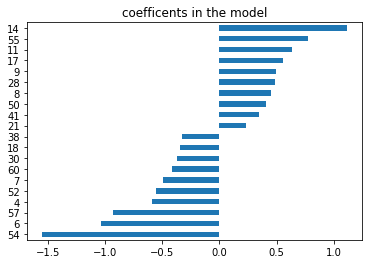

In [ ]:
import matplotlib.pyplot as plt

coef = pd.Series([item for sublist in clf.coef_ for item in sublist])
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

imp_coef.plot(kind="barh")
plt.title("coefficents in the model")